In [126]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [52]:
train = pd.read_csv('AMES_TRAIN.csv')
test = pd.read_csv('AMES_TEST_SFAM.csv')
train.columns = [s.lower() for s in train.columns]
test.columns = [s.lower() for s in test.columns]
train['qualityindex'] = (train.overallqual*train.overallcond)
train['totalsqftcalc'] = (train.bsmtfinsf1+train.bsmtfinsf2+train.grlivarea)
test['qualityindex'] = (test.overallqual*test.overallcond)
test['totalsqftcalc'] = (test.bsmtfinsf1+test.bsmtfinsf2+test.grlivarea)
train ['log_saleprice'] = np.log(train['saleprice'])
test ['log_saleprice'] = test['saleprice']
train=train.replace({'totalsqftcalc': {np.NaN : 10000}})
train=train.replace({'lotarea': {np.NaN : 10000}})
train=train.replace({'lotfrontage': {np.NaN : 10000}})
test=test.replace({'totalsqftcalc': {np.NaN : 10000}})
test=test.replace({'lotarea': {np.NaN : 10000}})
test=test.replace({'lotfrontage': {np.NaN : 10000}})
test["garagearea"] = test['garagearea'].fillna(0)
#added to fix issue with blank cell

In [53]:
train = train[train['totalsqftcalc'] < 6000]
train = train[train['salecondition'] == 'Normal']
train = train[train['saleprice'] <= 500000]
train = train[train['lotarea'] <= 25000]
train = train[train['zoning'] != 'I']
train = train[train['zoning'] != 'C']
train = train[train['zoning'] != 'A']

In [54]:
#train = train[train['roofstyle'] != 'Gable']
#train = train[train['roofstyle'] != 'Hip']

In [55]:
test.head()
#print(test.head())

,index,p_saleprice,saleprice,subclass,zoning,lotfrontage,lotarea,street,alley,lotshape,...,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,qualityindex,totalsqftcalc,log_saleprice
0,1,NaN,NaN,30,C,69.0,12366,Pave,NaN,Reg,...,NaN,NaN,0,10,2006,WD,Abnorml,15,729,NaN
1,4,NaN,NaN,20,FV,65.0,8125,Pave,NaN,Reg,...,NaN,NaN,0,10,2009,New,Partial,40,1836,NaN
2,7,NaN,NaN,60,RL,80.0,9760,Pave,NaN,Reg,...,MnWw,NaN,0,7,2007,WD,Normal,48,2504,NaN
3,11,NaN,NaN,20,RL,76.0,10141,Pave,NaN,IR1,...,NaN,NaN,0,1,2009,WD,Normal,40,2802,NaN
4,13,NaN,NaN,20,RL,103.0,11175,Pave,NaN,IR1,...,NaN,NaN,0,10,2007,New,Partial,35,1316,NaN


In [56]:
#print(train)

In [57]:
#train['saleprice'] = np.log(['saleprice'])
np.log(train['saleprice']).head()

0    12.373703
1    12.138864
2    11.635143
3    12.154779
4    11.918391
Name: saleprice, dtype: float64

In [58]:
X = train[['saleprice','qualityindex','totalsqftcalc','yearbuilt','lotarea','lotfrontage']].copy()
X1 = train[['qualityindex','totalsqftcalc','yearbuilt','lotarea','lotfrontage']].copy()
corr = X[X.columns].corr()
#corr

In [59]:
Y = train[['saleprice']].copy()
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
select_top_3 = SelectKBest(score_func=chi2, k = 3)
fit = select_top_3.fit(X1,Y)
features = fit.transform(X1)
#features[0:5] 

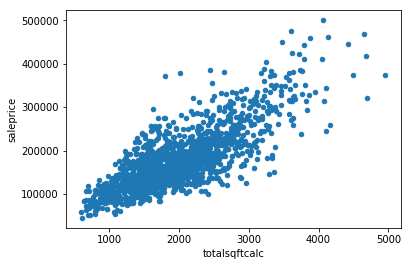

In [60]:
train.plot.scatter(y='saleprice', x='totalsqftcalc') 
#This lets me see some outliars that could be distorting the data.

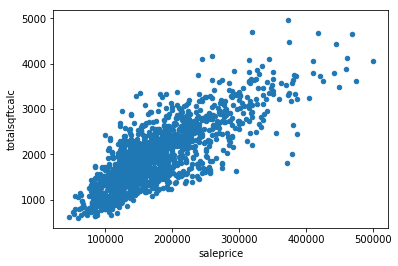

In [61]:
train.plot.scatter(y='totalsqftcalc', x='saleprice') 

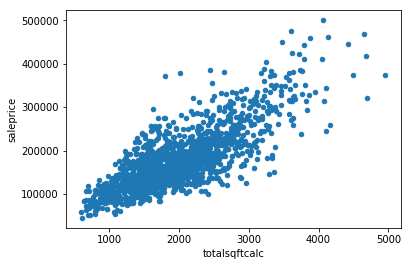

In [62]:
train.plot.scatter(y='saleprice', x='totalsqftcalc') 

In [85]:
model4 = smf.ols(formula='saleprice ~ qualityindex+totalsqftcalc+totalbsmtsf+garagearea+bsmtunfsf+yearbuilt+neighborhood', data=train).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     435.3
Date:                Thu, 14 Feb 2019   Prob (F-statistic):               0.00
Time:                        01:19:46   Log-Likelihood:                -18723.
No. Observations:                1645   AIC:                         3.751e+04
Df Residuals:                    1612   BIC:                         3.769e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -8

In [93]:
#previous way I was doing VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
#VIF for Model 4
# Break into left and right hand side; y and X
Y, X = dmatrices( "saleprice ~ qualityindex+totalsqftcalc+totalbsmtsf+grlivarea+garagearea+yearbuilt+neighborhood", data=train, return_type="dataframe")
# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Fit X to y
result = smf.OLS(Y, X).fit()
#print(vif)

In [94]:
#Model 4 VIF (this way I was able to label each output)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = pd.Series(vif, index =X.columns)
print("This is the VIF for Model 5 non-log")
print(vif)
#tried dropping neighborhood due to high scores vs. other variables but hurt model score on kaggle

This is the VIF for Model 5 non-log
Intercept                  22053.844215
neighborhood[T.Blueste]        1.800078
neighborhood[T.BrDale]         2.963730
neighborhood[T.BrkSide]        9.946482
neighborhood[T.ClearCr]        3.542099
neighborhood[T.CollgCr]       16.752300
neighborhood[T.Crawfor]        8.777780
neighborhood[T.Edwards]       14.713771
neighborhood[T.Gilbert]       10.193750
neighborhood[T.Greens]         1.694636
neighborhood[T.GrnHill]        1.114889
neighborhood[T.IDOTRR]         5.670744
neighborhood[T.MeadowV]        3.554256
neighborhood[T.Mitchel]        8.210373
neighborhood[T.NAmes]         27.629309
neighborhood[T.NPkVill]        2.810689
neighborhood[T.NWAmes]         9.115227
neighborhood[T.NoRidge]        5.992755
neighborhood[T.NridgHt]        7.932105
neighborhood[T.OldTown]       19.082966
neighborhood[T.SWISU]          3.529132
neighborhood[T.Sawyer]        10.876325
neighborhood[T.SawyerW]        9.036756
neighborhood[T.Somerst]        9.404371
neig

In [80]:
test_predictions_2 = model4.predict(test)
d = {'p_saleprice': test_predictions_2}
df1 = test[['index']]
df2=pd.DataFrame(data=d)
Strouse_TestPredictions_2 = pd.concat([df1,df2],axis = 1, join_axes=[df1.index])
Strouse_TestPredictions_2.head()

,index,p_saleprice
0,1,30958.809272
1,4,247184.247085
2,7,204785.304764
3,11,240823.366620
4,13,180451.353554


In [125]:
Strouse_TestPredictions_2.to_csv('logan_strouse_HW2_model_4_scored_final.csv')

In [95]:
model5 = smf.ols(formula='log_saleprice ~ qualityindex+totalsqftcalc+totalbsmtsf+garagearea+bsmtunfsf+yearbuilt+neighborhood', data=train).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:          log_saleprice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     565.4
Date:                Thu, 14 Feb 2019   Prob (F-statistic):               0.00
Time:                        02:42:36   Log-Likelihood:                 1424.0
No. Observations:                1645   AIC:                            -2782.
Df Residuals:                    1612   BIC:                            -2604.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [96]:
#VIF for Model 5
# Break into left and right hand side; y and X
Y, X = dmatrices( "log_saleprice ~ qualityindex+totalsqftcalc+totalbsmtsf+garagearea+bsmtunfsf+yearbuilt+neighborhood", data=train, return_type="dataframe")
# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Fit X to y
result = smf.OLS(Y, X).fit()

In [97]:
#Model 5 VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = pd.Series(vif, index =X.columns)
print("This is the VIF for Model 5 (Log-Transformed Model)")
print(vif)
#Vif's overall are passable

This is the VIF for Model 5 (Log-Transformed Model)
Intercept                  22053.844215
neighborhood[T.Blueste]        1.800078
neighborhood[T.BrDale]         2.963730
neighborhood[T.BrkSide]        9.946482
neighborhood[T.ClearCr]        3.542099
neighborhood[T.CollgCr]       16.752300
neighborhood[T.Crawfor]        8.777780
neighborhood[T.Edwards]       14.713771
neighborhood[T.Gilbert]       10.193750
neighborhood[T.Greens]         1.694636
neighborhood[T.GrnHill]        1.114889
neighborhood[T.IDOTRR]         5.670744
neighborhood[T.MeadowV]        3.554256
neighborhood[T.Mitchel]        8.210373
neighborhood[T.NAmes]         27.629309
neighborhood[T.NPkVill]        2.810689
neighborhood[T.NWAmes]         9.115227
neighborhood[T.NoRidge]        5.992755
neighborhood[T.NridgHt]        7.932105
neighborhood[T.OldTown]       19.082966
neighborhood[T.SWISU]          3.529132
neighborhood[T.Sawyer]        10.876325
neighborhood[T.SawyerW]        9.036756
neighborhood[T.Somerst]     

In [105]:
#dir(model2)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 0 to 2038
Data columns (total 85 columns):
subclass         1645 non-null int64
zoning           1645 non-null object
lotfrontage      1645 non-null float64
lotarea          1645 non-null int64
street           1645 non-null object
alley            109 non-null object
lotshape         1645 non-null object
landcontour      1645 non-null object
utilities        1645 non-null object
lotconfig        1645 non-null object
landslope        1645 non-null object
neighborhood     1645 non-null object
condition1       1645 non-null object
condition2       1645 non-null object
bldgtype         1645 non-null object
housestyle       1645 non-null object
overallqual      1645 non-null int64
overallcond      1645 non-null int64
yearbuilt        1645 non-null int64
yearremodel      1645 non-null int64
roofstyle        1645 non-null object
roofmat          1645 non-null object
exterior1        1645 non-null object
exterior2        1645 non

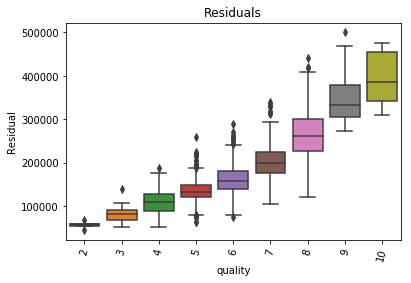

In [108]:
#residuals
#This one was done for fun

train['residual'] = (train.saleprice-train.log_saleprice)

import seaborn as sns
ax = sns.boxplot(x="overallqual", y="residual", data=train)
ax.set_title("Residuals")
ax.set_ylabel("Residual")
ax.set_xlabel("quality")
plt.xticks(rotation=75)
plt.show()

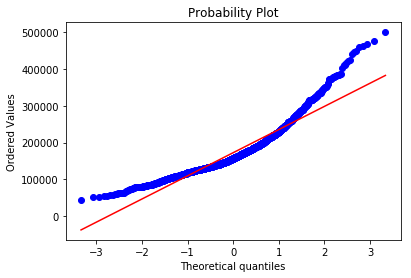

In [123]:
import numpy as np 
import pylab 
import scipy.stats as stats  
stats.probplot(train.residual, dist="norm", plot=pylab)
pylab.show()